In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv, global_mean_pool
import numpy as np
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import networkx as nx

In [16]:
# 1) feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        res = resnet18(pretrained=pretrained)
        # remove final FC
        self.backbone = nn.Sequential(*list(res.children())[:-2])  # output: [B, 512, H', W']
    def forward(self, x):
        return self.backbone(x)  # feature map

In [17]:
# 2) simple GAT model
class GATClassifier(nn.Module):
    def __init__(self, in_dim, hid=64, heads=4, n_classes=10):
        super().__init__()
        self.gat1 = GATConv(in_dim, hid//heads, heads=heads, concat=True)
        self.gat2 = GATConv(hid, hid//heads, heads=heads, concat=True)
        self.pool = global_mean_pool
        self.fc = nn.Linear(hid, n_classes)
    def forward(self, x, edge_index, batch):
        x, (edge_idx1, attn1) = self.gat1(x, edge_index, return_attention_weights=True)
        x = x.relu()
        x, (edge_idx2, attn2) = self.gat2(x, edge_index, return_attention_weights=True)
        x = x.relu()
        out = self.pool(x, batch)
        logits = self.fc(out)
        return logits, x, (edge_idx1, attn1), (edge_idx2, attn2)

In [18]:
# 3) helper: image -> superpixel graph
def image_to_superpixel_graph(img_tensor, extractor, n_segments=50):
    # img_tensor: [3,H,W], values in [0,1]
    img_np = img_tensor.permute(1,2,0).cpu().numpy()
    segments = slic(img_np, n_segments=n_segments, compactness=10)
    # get feature map and pool per segment
    with torch.no_grad():
        extractor.eval()
        fmap = extractor(img_tensor.unsqueeze(0))  # [1,C,Hf,Wf]
    fmap = fmap.squeeze(0).cpu().numpy()  # C,Hf,Wf
    # Map superpixel to nodes by upsampling fmap to input size (simple approach)
    # For demo: average pixel RGB in each superpixel as node features
    H,W = img_np.shape[:2]
    nodes = []
    for s in np.unique(segments):
        mask = (segments == s)
        feat = img_np[mask].mean(axis=0)  # RGB average
        nodes.append(feat)
    x = torch.tensor(np.vstack(nodes), dtype=torch.float)  # [N,3]
    # edge construction: connect adjacent superpixels (boundary > 0)
    import networkx as nx
    G = nx.grid_2d_graph(H, W)  # placeholder; better: compute adjacency from segments
    # Simpler: complete graph with similarity threshold for demo
    N = x.shape[0]
    edges = []
    for i in range(N):
        for j in range(i+1,N):
            sim = torch.cosine_similarity(x[i:i+1], x[j:j+1]).item()
            if sim > 0.9:  # threshold demo
                edges.append([i,j]); edges.append([j,i])
    if len(edges)==0: # fallback connect ring
        for i in range(N-1):
            edges.append([i,i+1]); edges.append([i+1,i])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=x, edge_index=edge_index)
    data.batch = torch.zeros(x.shape[0], dtype=torch.long)  # single graph batch
    return data, segments

In [19]:
# Demo: load example
transform = T.Compose([T.ToTensor()])
ds = CIFAR10(root='./data', train=False, download=True, transform=transform)
img, label = ds[0]
extractor = FeatureExtractor(pretrained=False)
data, segments = image_to_superpixel_graph(img, extractor, n_segments=30)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
model = GATClassifier(in_dim=data.x.shape[1], n_classes=10)
logits, node_emb, (edge_idx1, attn1), _ = model(data.x, data.edge_index, data.batch)
print("Logits:", logits)

Logits: tensor([[-0.0757, -0.1252,  0.0354, -0.0783,  0.0757,  0.0074,  0.0697, -0.0035,
         -0.1192, -0.0357]], grad_fn=<AddmmBackward0>)


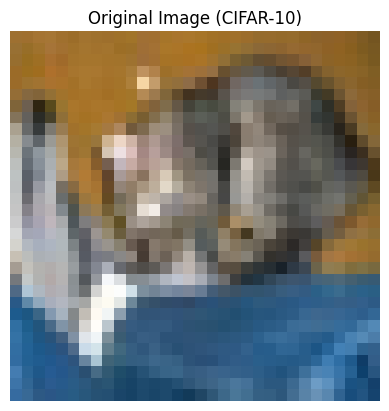

In [21]:
# Visualization demo
plt.imshow(img.permute(1,2,0))
plt.title("Original Image (CIFAR-10)")
plt.axis('off')
plt.show()

In [22]:
edge_idx_np = edge_idx1.cpu().numpy()
attn_np = attn1.mean(dim=1).cpu().detach().numpy()

num_nodes = data.x.shape[0]
node_importance = np.zeros(num_nodes)

# Aggregate attention weights per destination node
for i, (src, dst) in enumerate(edge_idx_np.T):
    node_importance[dst] += attn_np[i]

# Normalize safely
node_importance /= (np.max(node_importance) + 1e-8)
top_nodes = np.argsort(node_importance)[-5:]
print("Top important nodes:", top_nodes)

Top important nodes: [13 15 16  2  1]


In [23]:
edge_index_np = data.edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(list(zip(edge_index_np[0], edge_index_np[1])))

props = regionprops(segments + 1)
centroids = [p.centroid for p in props]

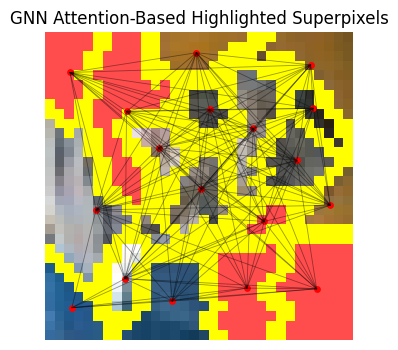

In [24]:
highlighted = img.permute(1,2,0).cpu().numpy().copy()
mask = np.zeros_like(segments, dtype=bool)
for node_id in top_nodes:
    if node_id < len(np.unique(segments)):
        mask |= (segments == node_id)
highlighted[mask] = [1.0, 0.3, 0.3]  # red tint

plt.figure(figsize=(4,4))
plt.imshow(mark_boundaries(highlighted, segments))
for (i, j) in G.edges():
    y0, x0 = centroids[i]
    y1, x1 = centroids[j]
    plt.plot([x0, x1], [y0, y1], 'black', linewidth=0.6, alpha=0.4)
plt.scatter([c[1] for c in centroids], [c[0] for c in centroids],
            c='red', s=15)
plt.title("GNN Attention-Based Highlighted Superpixels")
plt.axis('off')
plt.show()

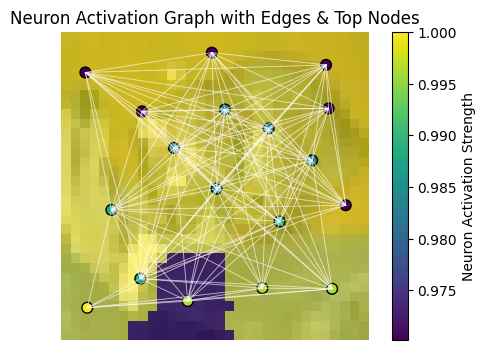

In [32]:
activation_strength = node_emb.norm(p=2, dim=1).cpu().detach().numpy()
activation_strength /= (np.percentile(activation_strength, 95) + 1e-8)  # smoother normalization
activation_strength = np.clip(activation_strength, 0, 1)

# Map activations to superpixels
act_map = np.zeros_like(segments, dtype=float)
for node_id in range(min(len(activation_strength), len(np.unique(segments)))):
    act_map[segments == node_id] = activation_strength[node_id]

# Plot activation map
plt.figure(figsize=(6,4))
plt.imshow(img.permute(1,2,0))
plt.imshow(act_map, cmap='viridis', alpha=0.6, vmin=0.2, vmax=1.0)
for (i, j) in edge_idx1.T.cpu().numpy():
    y0, x0 = centroids[i]
    y1, x1 = centroids[j]
    plt.plot([x0, x1], [y0, y1], color='white', alpha=0.4, linewidth=0.6)

# Scatter all nodes, color by activation
sc = plt.scatter([c[1] for c in centroids], [c[0] for c in centroids],
                 c=activation_strength, cmap='viridis', s=60, edgecolors='black')


plt.colorbar(sc, label='Neuron Activation Strength')
plt.title("Neuron Activation Graph with Edges & Top Nodes")
plt.axis('off')
plt.show()